In this notebook we will be building and training LSTM to predict APPLE stock. We will use PyTorch.

## 1. Libraries and settings

In [1]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

## 2. Load data

In [2]:
def stocks_data(symbols, dates):
    df = pd.DataFrame(index=dates)
    for symbol in symbols:
        df_temp = pd.read_csv("Data/{}.txt".format(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', 'Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Close': symbol})
        df = df.join(df_temp)
    return df

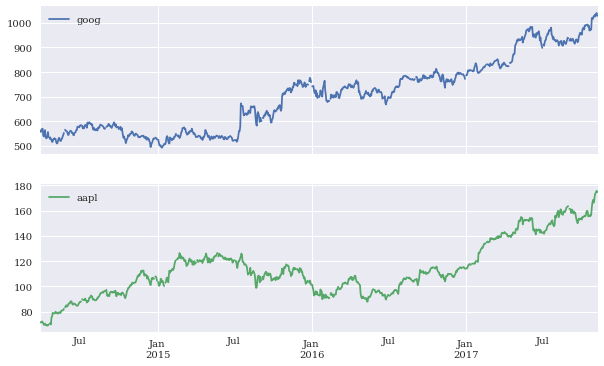

In [3]:
dates = pd.date_range('2014-03-27','2017-11-10',freq='B')
symbols = ['goog','aapl']
df = stocks_data(symbols, dates)
df.fillna(method='pad')
df.plot(figsize=(10, 6), subplots=True);

In [4]:
df.head()

,goog,aapl
2014-03-27,558.46,71.611
2014-03-28,559.99,71.531
2014-03-31,556.97,71.513
2014-04-01,567.16,72.168
2014-04-02,567.00,72.290


Text(0.5, 1.0, 'APPLE Stock')

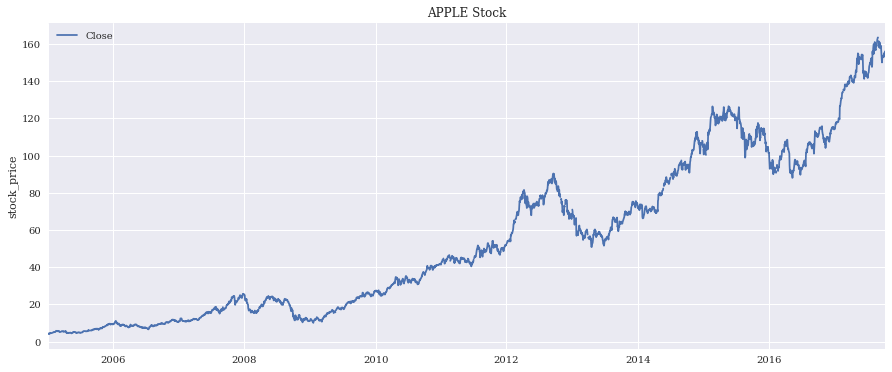

In [5]:
dates = pd.date_range('2005-01-03','2017-10-11',freq='B')
df1=pd.DataFrame(index=dates)
df_aapl=pd.read_csv("Data/aapl.txt", parse_dates=True, index_col=0)
df_aapl=df1.join(df_aapl)
df_aapl[['Close']].plot(figsize=(15, 6))
plt.ylabel("stock_price")
plt.title("APPLE Stock")

In [6]:
df_aapl=df_aapl[['Close']]
df_aapl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3333 entries, 2005-01-03 to 2017-10-11
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3217 non-null   float64
dtypes: float64(1)
memory usage: 181.1 KB


In [7]:
df_aapl=df_aapl.fillna(method='ffill')

scaler = MinMaxScaler(feature_range=(-1, 1))
df_aapl['Close'] = scaler.fit_transform(df_aapl['Close'].values.reshape(-1,1))
df_aapl

,Close
2005-01-03,-1.000000
2005-01-04,-0.999472
2005-01-05,-0.999020
2005-01-06,-0.998990
2005-01-07,-0.995211
...,...
2017-10-05,0.891724
2017-10-06,0.890595
2017-10-09,0.897370
2017-10-10,0.898123


In [8]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 60 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df_aapl, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2618, 59, 1)
y_train.shape =  (2618, 1)
x_test.shape =  (655, 59, 1)
y_test.shape =  (655, 1)


In [9]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [10]:
y_train.size(),x_train.size()

(torch.Size([2618, 1]), torch.Size([2618, 59, 1]))

## 3. Build the structure of model

In [11]:
# Build model
#####################
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [12]:
# Train model
#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.043863099068403244
Epoch  20 MSE:  0.004615033511072397
Epoch  30 MSE:  0.0031680220272392035
Epoch  40 MSE:  0.0013683086726814508
Epoch  50 MSE:  0.0009035820257849991
Epoch  60 MSE:  0.0004629928444046527
Epoch  70 MSE:  0.0004149343294557184
Epoch  80 MSE:  0.00034900210448540747
Epoch  90 MSE:  0.00033109946525655687


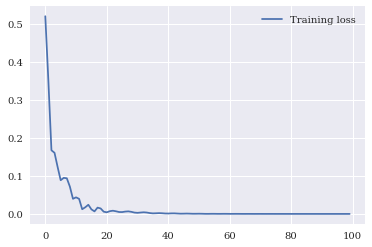

In [13]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [14]:
np.shape(y_train_pred)

torch.Size([2618, 1])

In [15]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.43 RMSE
Test Score: 8.23 RMSE


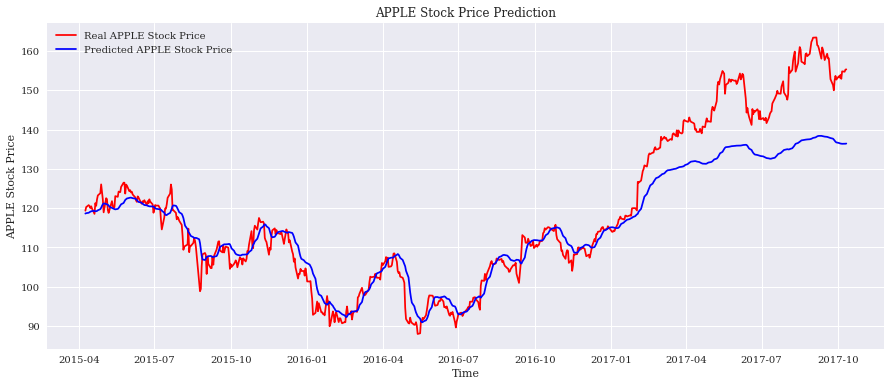

In [16]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df_aapl[len(df_aapl)-len(y_test):].index, y_test, color = 'red', label = 'Real APPLE Stock Price')
axes.plot(df_aapl[len(df_aapl)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted APPLE Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('APPLE Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('APPLE Stock Price')
plt.legend()
plt.savefig('apple_pred.png')